# Fashion-MNIST Custom Neural Network Training
University of Ljubljana, Faculty of Computer and Information Science
Course: Machine Learning, 2024-2025

Teodora Taleska

## Environment Setup

In [2]:
import torch
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from helpers import performance

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Data

Load the Fashion-MNIST dataset from the official Fashion-MNIST GitHub repository using the `utils.mnist_reader` module. The dataset consists of 60,000 training samples, each belonging to one of 10 fashion-related classes. Then, normalize the training sample values to the range [0, 1] and visualize one random member from each of the 10 classes.


In [4]:
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return data

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

train_images = load_mnist_images('../data/fashion/train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('../data/fashion/train-labels-idx1-ubyte.gz')
test_images = load_mnist_images('../data/fashion/t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('../data/fashion/t10k-labels-idx1-ubyte.gz')

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


### Normalize the Data

After loading the data, normalize the pixel values of the training samples to the range [0, 1]. This step ensures that all features are on a consistent scale, making them suitable for use in neural network model. The normalization is performed by dividing each pixel value by 255, which is the maximum possible intensity in the dataset.

In [5]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# reshaping images to [N, 1, 28, 28] and convert to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1) / 255.0
val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1) / 255.0
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1) / 255.0

# convert labels to integer class indices before one-hot encoding
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_labels = F.one_hot(train_labels, num_classes=10).float()
val_labels = F.one_hot(val_labels, num_classes=10).float()
test_labels = F.one_hot(test_labels, num_classes=10).float()

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

Train images shape: torch.Size([48000, 1, 28, 28]), Train labels shape: torch.Size([48000, 10])
Validation images shape: torch.Size([12000, 1, 28, 28]), Validation labels shape: torch.Size([12000, 10])
Test images shape: torch.Size([10000, 1, 28, 28]), Test labels shape: torch.Size([10000, 10])


In [6]:
# transferring the data to the available device (GPU or CPU)
train_images = train_images.to(device)
val_images = val_images.to(device)
test_images = test_images.to(device)

train_labels = train_labels.to(device)
val_labels = val_labels.to(device)
test_labels = test_labels.to(device)

print('Data transferred to device.', device)
print(f"Train images device: {train_images.device}")

Data transferred to device. cuda
Train images device: cuda:0


### Visualization
Visualization of one random member from each of the 10 classes in the training dataset.

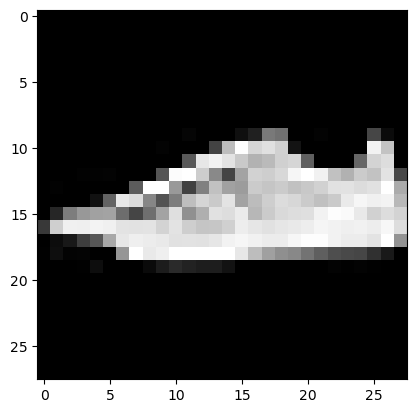

In [29]:
# accessing the first image - single channel
plt.imshow(train_images[0, 0].cpu().numpy(), cmap='gray') 
plt.show()

In [6]:
def visualize_random_per_class(images, labels):
    """
    Visualize one random example from each label class.

    Parameters:
    - images: Tensor of images [N, C, H, W]
    - labels: Tensor of one-hot encoded labels [N, num_classes]
    """
    # Convert one-hot encoded labels back to integer class indices
    label_indices = torch.argmax(labels, dim=1)
    
    # Get the unique class labels in the dataset
    unique_classes = label_indices.unique(sorted=True)
    
    fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 3))
    
    for i, class_value in enumerate(unique_classes):
        # Get all indices of the current class
        class_indices = (label_indices == class_value).nonzero(as_tuple=True)[0]
        
        # Select a random index from the current class
        random_idx = np.random.choice(class_indices.cpu().numpy())
        
        # Retrieve the corresponding image and actual label value
        image = images[random_idx].squeeze()  # Remove channel dimension
        label = class_value.item()  # Convert tensor to Python scalar
        
        axes[i].imshow(image.cpu().numpy(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")
    
    plt.tight_layout()
    plt.show()

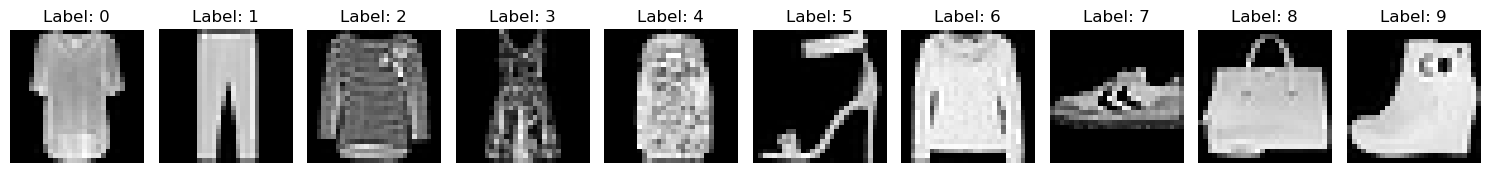

In [33]:
visualize_random_per_class(train_images, train_labels)

## Implementing the Dataset Class
In this section, I define a custom `Dataset` class to handle batched and shuffled data for training and validation. The class supports the following functionalities:
- Initialization of the dataset with samples, labels, and batch size.
- Batch-wise access to data using the `__getitem__` method.
- Determining the number of batches using the `__len__` method.
- Shuffling the dataset samples and labels using the `shuffle` method.


In [7]:
class Dataset:
    def __init__(self, samples, labels, batch_size):
        """
        Initialize the dataset with samples, labels, and batch size.
        
        Args:
            samples (torch.Tensor): The dataset samples of shape [N, 1, 28, 28].
            labels (torch.Tensor): The dataset labels of shape [N, num_classes].
            batch_size (int): The number of samples per batch.
        """
        self.samples = samples
        self.labels = labels
        self.batch_size = batch_size
        self.indices = torch.arange(len(samples))  # Initialize indices for deterministic access
    
    def __getitem__(self, index):
        """
        Return the batch of samples and labels corresponding to the given index.
        
        Args:
            index (int): The batch index.
            
        Returns:
            batch_samples (torch.Tensor): The batch samples of shape [batch_size, 1, 28, 28].
            batch_labels (torch.Tensor): The batch labels of shape [batch_size, num_classes].
        """
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.samples))  # Handle last batch
        batch_indices = self.indices[start_idx:end_idx]
        return self.samples[batch_indices], self.labels[batch_indices]
    
    def __len__(self):
        """
        Return the number of batches in the dataset.
        
        Returns:
            int: The number of batches.
        """
        return (len(self.samples) + self.batch_size - 1) // self.batch_size
    
    def shuffle(self):
        """
        Shuffle the dataset samples and labels by permuting the indices.
        """
        self.indices = torch.randperm(len(self.samples))

train_dataset = Dataset(train_images, train_labels, batch_size=64)
val_dataset = Dataset(val_images, val_labels, batch_size=64)

In [7]:
batch1_a, labels1_a = train_dataset[1]
batch1_b, labels1_b = train_dataset[1]
assert torch.equal(batch1_a, batch1_b) and torch.equal(labels1_a, labels1_b), "Batches are not deterministic!"
print("Determinism confirmed!")

Determinism confirmed!


### Visualize the data
Visualization of 16 samples from a batch belonging to the training dataset and their corresponding class labels.

In [36]:
num_train_batches = len(train_dataset)
print(f"Number of batches in the training dataset: {num_train_batches}")

num_val_batches = len(val_dataset)
print(f"Number of batches in the validation dataset: {num_val_batches}")

Number of batches in the training dataset: 750
Number of batches in the validation dataset: 188


In [39]:
print(f"Unique train labels: {torch.unique(train_labels)}")
print(f"Unique test labels: {torch.unique(test_labels)}")

Unique train labels: tensor([0., 1.], device='cuda:0')
Unique test labels: tensor([0., 1.], device='cuda:0')


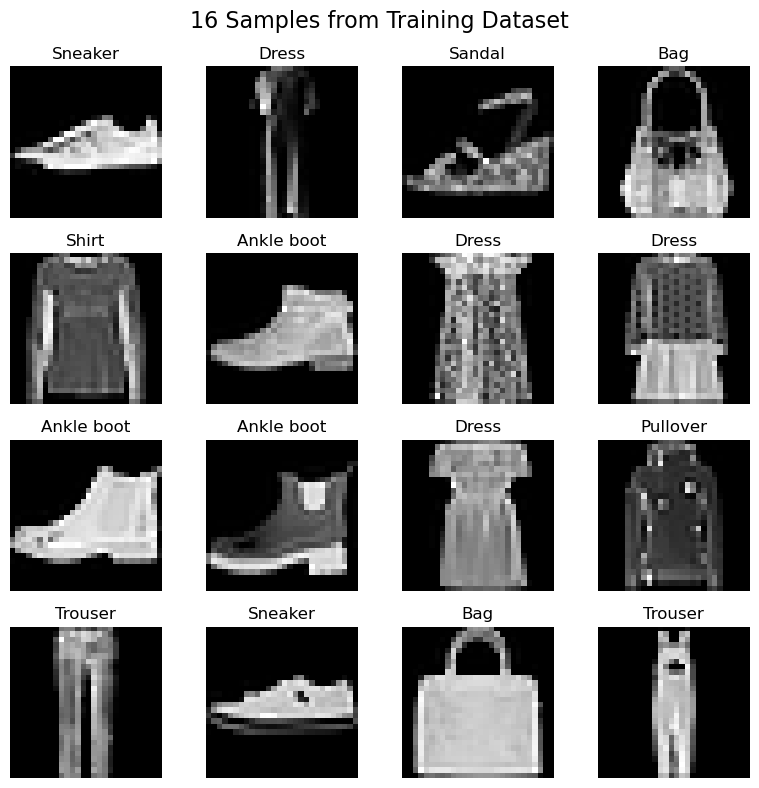

In [41]:
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

batch_samples, batch_labels = train_dataset[0]

images = batch_samples[:16].squeeze(1).cpu().numpy()
labels = torch.argmax(batch_labels[:16], dim=1).cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("16 Samples from Training Dataset", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap="gray")
    ax.set_title(f"{label_names[labels[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Implementing Basic Operations for Neural Networks
This section implements three foundational operations for our neural network:
- 2D Convolution: A manual implementation of convolution to extract spatial features.
- 2D Max Pooling: A manual downsampling of input using a sliding window.
- ReLU Activation: A straightforward implementation of the Rectified Linear Unit (ReLU) function.

In [30]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        # Ensure input has the correct shape
        if x.dim() == 3:  # Add channel dimension for grayscale input
            x = x.unsqueeze(1)

        # Extract patches using unfold
        patches = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride)  # [batch_size, in_channels * kernel_size^2, L]
        patches = patches.transpose(1, 2)  # [batch_size, L, in_channels * kernel_size^2]

        # Reshape weight for matrix multiplication
        weight = self.weight.view(self.out_channels, -1).t()  # [in_channels * kernel_size^2, out_channels]

        # Perform matrix multiplication and add bias
        output = patches @ weight + self.bias  # [batch_size, L, out_channels]

        # Reshape to [batch_size, out_channels, out_height, out_width]
        out_height = (x.size(2) - self.kernel_size) // self.stride + 1
        out_width = (x.size(3) - self.kernel_size) // self.stride + 1
        output = output.transpose(1, 2).view(x.size(0), self.out_channels, out_height, out_width)

        return output

In [31]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride else kernel_size

    def forward(self, x):
        # Ensure input has the correct shape
        if x.dim() == 3:  # Add channel dimension for grayscale input
            x = x.unsqueeze(1)

        # Extract patches using unfold
        patches = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride)  # [batch_size, channels * kernel_size^2, L]
        
        # Reshape to [batch_size, channels, kernel_size^2, L]
        patches = patches.view(
            x.size(0), x.size(1), self.kernel_size * self.kernel_size, -1
        )

        # Max over the kernel dimensions
        output = patches.max(dim=2).values  # [batch_size, channels, L]

        # Reshape to [batch_size, channels, out_height, out_width]
        out_height = (x.size(2) - self.kernel_size) // self.stride + 1
        out_width = (x.size(3) - self.kernel_size) // self.stride + 1
        output = output.view(x.size(0), x.size(1), out_height, out_width)

        return output

In [32]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.maximum(x, torch.tensor(0.0, device=x.device))

### Testing the basic manually implemented operations and comparing them with PyTorch's built-in implementations on the first batch of the training dataset.

In [33]:
x, y = train_dataset[0]

In [34]:
print(x.device)

cuda:0


### Testing the functions in a sequential manner and comparing them with PyTorch's built-in implementations.
Custom layers

In [35]:
# Initialization
conv = Conv2d(in_channels=1, out_channels=16, kernel_size=3).to(device)
pool = MaxPool2d(kernel_size=2).to(device)
relu = ReLU().to(device)

# Forward pass
output_conv = conv(x)
output_pool = pool(output_conv)
output_relu = relu(output_pool)

PyTorch layers

In [36]:
# Initialization
conv_pytorch = nn.Conv2d(1, 16, kernel_size=3).to(device)
pool_pytorch = nn.MaxPool2d(kernel_size=2).to(device)
relu_pytorch = nn.ReLU().to(device)

conv_pytorch.weight.data = conv.weight.data
conv_pytorch.bias.data = conv.bias.data

# Forward pass
output_conv_pytorch = conv_pytorch(x)
output_pool_pytorch = pool_pytorch(output_conv_pytorch)
output_relu_pytorch = relu_pytorch(output_pool_pytorch)

In [37]:
conv_diff = torch.abs(output_conv - output_conv_pytorch).max()
pool_diff = torch.abs(output_pool - output_pool_pytorch).max()
relu_diff = torch.abs(output_relu - output_relu_pytorch).max()

print(f"Convolution difference: {conv_diff.item():.6f}")
print(f"Pooling difference: {pool_diff.item():.6f}")
print(f"ReLU difference: {relu_diff.item():.6f}")

if conv_diff < 1e-5 and pool_diff < 1e-5 and relu_diff < 1e-5:
    print("Test passed: The outputs are very close!")
else:
    print("Test failed: There is a noticeable difference.")

Convolution difference: 0.000000
Pooling difference: 0.000000
ReLU difference: 0.000000
Test passed: The outputs are very close!


### Commutativity Test of MaxPool2d and ReLU Operations

In [38]:
# random tensor in the range [-1, 1] with dimensions [1, 100, 100]
x = torch.rand(1, 100, 100) * 2 - 1
x.to(device)

print(f"Tensor shape: {x.shape}")

maxpool = MaxPool2d(kernel_size=3, stride=2).to(device)
relu = ReLU().to(device)

# Transformation 1: MaxPool2d followed by ReLU
output1 = relu(maxpool(x))

# Transformation 2: ReLU followed by MaxPool2d
output2 = maxpool(relu(x))

output_diff = torch.abs(output1 - output2).max()

print(f"Max difference between outputs: {output_diff.item():.6f}")

if output_diff < 1e-5:
    print("Test passed: The outputs are very close!")
else:
    print("Test failed: There is a noticeable difference.")

Tensor shape: torch.Size([1, 100, 100])
Max difference between outputs: 0.000000
Test passed: The outputs are very close!


### Observations
1. Observing the MaxPool2d and ReLU commutativity. 
- The fact that there is no difference in the outputs suggests that the order of applying the operations does not affect the final result and the functions are commutative.
- To explain this mathematically:
    - ReLU is a non-linear activation function that applies the element-wise operation `max(x, 0)` to the input tensor. It simply replaces any negative values with 0. 
    - MaxPool2d operation applies a sliding window (kernel) to find the maximum value in each window (patch) of the input tensor. If stride=2 and kernel_size=3, it computes the maximum value in a 3x3 patch and then moves the window by 2 steps in both the height and width directions.
- **MaxPool2d followed by ReLU**: After performing MaxPool2d, the resulting tensor has the maximum values from each region of the input tensor (depending on the kernel size and stride). Then, ReLU is applied, setting any negative values to 0.
- **ReLU followed by MaxPool2d**: In this case, ReLU first replaces negative values in the tensor with zeros. Afterward, MaxPool2d is applied, which calculates the maximum value within each patch, but now, the values within the patches have already been adjusted by ReLU.
- *Key observation*: The commutativity of MaxPool2d and ReLU holds in this specific case because ReLU only modifies negative values, and MaxPool2d computes maximum values, which would be unaffected by negative values as long as the patch contains at least one non-negative value.

2. Is the same true if we replace the maximal pooling operation with a convolution?
- The result may not be the same as with MaxPool2d, because convolutions have a more complex interaction with the input data due to the learnable filters and their weights. To test this, we can replace the MaxPool2d operation with a convolution and observe the output differences.
- **Mathematical explanation**: In the case of convolution followed by ReLU, the convolution operation applies a filter to the input and generates new values based on the learned kernel. Then, ReLU modifies the resulting values by setting any negative outputs to zero. On the other hand, ReLU followed by convolution first modifies the input tensor by setting negative values to zero and then applies the convolution operation to the modified tensor.

In [39]:
x = x.to(device)

conv = Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2).to(device)
relu = ReLU().to(device)

# Transformation 1: Conv2d followed by ReLU
output1 = relu(conv(x))

# Transformation 2: ReLU followed by Conv2d
output2 = conv(relu(x))

output_diff = torch.abs(output1 - output2).max()

print(f"Max difference between outputs: {output_diff.item():.6f}")

if output_diff < 1e-5:
    print("Test passed: The outputs are very close!")
else:
    print("Test failed: There is a noticeable difference.")


Max difference between outputs: 2.168958
Test failed: There is a noticeable difference.


### Defining the Neural Network Architecture
#### 1. Using custom layers:

In [40]:
class CustomNet(nn.Module):
    def __init__(self):
        super().__init__()

        # First Block: Conv2d -> MaxPool2d -> ReLU
        self.block1 = nn.Sequential(
            Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),  
            MaxPool2d(kernel_size=3, stride=2),  
            ReLU()  
        )

        # Second Block: Conv2d -> MaxPool2d -> ReLU
        self.block2 = nn.Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),  
            MaxPool2d(kernel_size=3, stride=2),  
            ReLU()  
        )

        # Final Conv2d Layer with kernel_size 4 and 10 output channels
        self.final_conv = Conv2d(in_channels=64, out_channels=10, kernel_size=4)

        # Flattening the output tensor
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.final_conv(x)
        x = self.flatten(x)

        return x

In [41]:
x, y = train_dataset[0]
model = CustomNet().to(device)
output = model(x)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([64, 10])


#### 2. Using PyTorch built-in layers:

In [42]:
class BuiltInNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),  
            nn.MaxPool2d(kernel_size=3, stride=2),  
            nn.ReLU()  
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),  
            nn.MaxPool2d(kernel_size=3, stride=2),  
            nn.ReLU()  
        )

        self.final_conv = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=4)

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.final_conv(x)
        x = self.flatten(x)
        
        return x

In [43]:
x, _ = train_dataset[0]
model2 = BuiltInNet().to(device)
output2 = model2(x)
print(f"Output shape: {output2.shape}")

Output shape: torch.Size([64, 10])


### Defining the 'fit' function
Using the Stochastic Gradient Descent algorithm and the Cross-Entropy loss function we define the fit function, which takes in two parameters: the model we wish to fit and the number of epochs, denoting the number of times you will iterate over the training and validation datasets.

In [44]:
class NNTrainer:
    def __init__(self, train_dataset, val_dataset, device):
        """
        Initialize the trainer with the datasets and the device.
        
        Args:
            train_dataset (Dataset): The training dataset object.
            val_dataset (Dataset): The validation dataset object.
            device (torch.device): The device to train the model on (e.g., 'cuda' or 'cpu').
        """
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.device = device

    def fit(self, model, number_of_epochs):
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        training_losses = []
        validation_losses = []

        best_model = None
        best_val_loss = float('inf')

        for epoch in range(number_of_epochs):
            model.train()
            running_train_loss = 0.0

            # Shuffle the training data at the beginning of each epoch
            self.train_dataset.shuffle()

            # Iterate over the batches of the training data manually
            for batch_idx in range(len(self.train_dataset)):
                inputs, targets = self.train_dataset[batch_idx]
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, targets)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item()

            avg_train_loss = running_train_loss / len(self.train_dataset)
            training_losses.append(avg_train_loss)

            model.eval()
            running_val_loss = 0.0

            # Disable gradient tracking to speed up inference and save memory
            with torch.no_grad():
                for batch_idx in range(len(self.val_dataset)):
                    inputs, targets = self.val_dataset[batch_idx]
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    running_val_loss += loss.item()

            avg_val_loss = running_val_loss / len(self.val_dataset)
            validation_losses.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = model.state_dict()

            print(f"Epoch {epoch + 1}/{number_of_epochs}, "
                  f"Training Loss: {avg_train_loss:.4f}, "
                  f"Validation Loss: {avg_val_loss:.4f}")

        return best_model, training_losses, validation_losses


In [45]:
custom_model = CustomNet().to(device)
builtin_model = BuiltInNet().to(device)

In [46]:
trainer = NNTrainer(train_dataset, val_dataset, device)

In [47]:
builtin_best_model, builtin_train_losses, builtin_val_losses = trainer.fit(builtin_model, 10)

Epoch 1/10, Training Loss: 0.6887, Validation Loss: 0.4836
Epoch 2/10, Training Loss: 0.4448, Validation Loss: 0.4315
Epoch 3/10, Training Loss: 0.3881, Validation Loss: 0.3686
Epoch 4/10, Training Loss: 0.3545, Validation Loss: 0.3533
Epoch 5/10, Training Loss: 0.3297, Validation Loss: 0.3667
Epoch 6/10, Training Loss: 0.3167, Validation Loss: 0.3181
Epoch 7/10, Training Loss: 0.3003, Validation Loss: 0.3127
Epoch 8/10, Training Loss: 0.2887, Validation Loss: 0.3052
Epoch 9/10, Training Loss: 0.2799, Validation Loss: 0.3184
Epoch 10/10, Training Loss: 0.2724, Validation Loss: 0.3039


In [48]:
custom_best_model, custom_train_losses, custom_val_losses = trainer.fit(custom_model, 10)

Epoch 1/10, Training Loss: 9.8963, Validation Loss: 2.3028
Epoch 2/10, Training Loss: 2.3030, Validation Loss: 2.3026
Epoch 3/10, Training Loss: 2.3030, Validation Loss: 2.3027
Epoch 4/10, Training Loss: 2.3030, Validation Loss: 2.3031
Epoch 5/10, Training Loss: 2.3030, Validation Loss: 2.3032
Epoch 6/10, Training Loss: 2.3030, Validation Loss: 2.3030
Epoch 7/10, Training Loss: 2.3031, Validation Loss: 2.3030
Epoch 8/10, Training Loss: 2.3030, Validation Loss: 2.3028
Epoch 9/10, Training Loss: 2.3031, Validation Loss: 2.3030
Epoch 10/10, Training Loss: 2.3031, Validation Loss: 2.3027


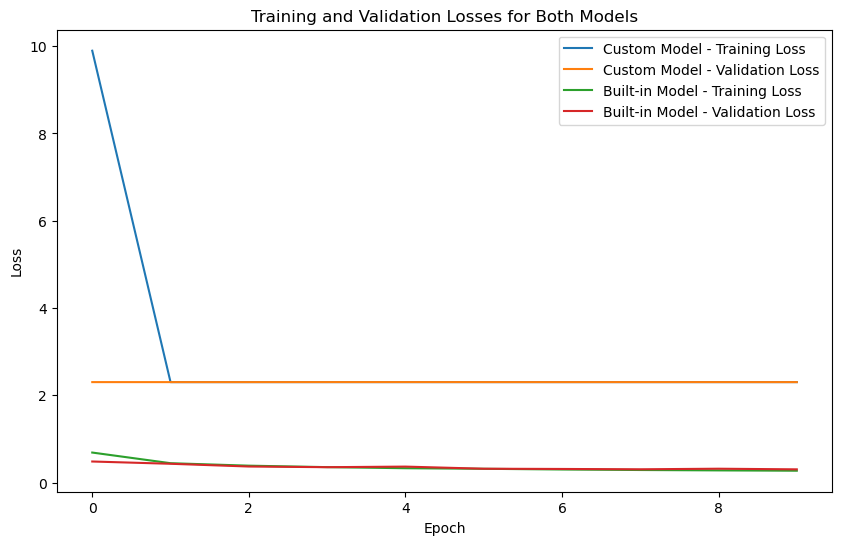

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(custom_train_losses, label='Custom Model - Training Loss')
plt.plot(custom_val_losses, label='Custom Model - Validation Loss')
plt.plot(builtin_train_losses, label='Built-in Model - Training Loss')
plt.plot(builtin_val_losses, label='Built-in Model - Validation Loss')

plt.title('Training and Validation Losses for Both Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
